In [1]:
import pandas as pd
import numpy as np
import random
import string
from datetime import datetime, timedelta

from pyspark.sql.functions import coalesce, lit, rand
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegressionModel, RandomForestClassificationModel
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

In [ ]:
packages = [
    'org.apache.hadoop:hadoop-aws:3.3.4',
    'org.apache.hadoop:hadoop-client-api:3.3.4',
    'org.apache.hadoop:hadoop-client-runtime:3.3.4',
]

conf = SparkConf() \
    .setAppName("MyApp") \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g") \
    .set('spark.jars.packages', ','.join(packages))

sc = SparkContext(conf=conf)

hadoop_config = sc._jsc.hadoopConfiguration()
hadoop_config.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
hadoop_config.set('com.amazonaws.services.s3.enableV4', 'true')

spark = SparkSession(sc)

In [44]:
from pyspark.sql import Row
from pyspark.sql.types import *

# Define the possible values for each column
colors = ["red", "blue", "green"]
types = ["SUV", "sedan", "truck"]
labels = ["class1", "class2", "class3"]
days_of_week = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Generate random data
data = []
for i in range(1000):
    id_val = i
    color_val = random.choice(colors)
    type_val = random.choice(types)
    localHour_val = random.randint(0, 23)
    milesperhour_val = round(random.uniform(15.0, 35.0), 1)
    age_val = random.randint(18, 80)
    label_val = random.choice(labels)
    date_val = f"2024-07-{random.randint(1, 31):02d}"
    geohash_val = f"u4pruydqqv{random.choice('abcdefghijklmnopqrstuvwxyz')}"
    dayOfWeek_val = random.choice(days_of_week)
    
    row = Row(id=id_val, color=color_val, type=type_val, localHour=localHour_val, milesperhour=milesperhour_val, age=age_val, label=label_val, date=date_val, geohash=geohash_val, dayOfWeek=dayOfWeek_val)
    data.append(row)

# Create DataFrame
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("color", StringType(), False),
    StructField("type", StringType(), False),
    StructField("localHour", IntegerType(), False),
    StructField("milesperhour", FloatType(), False),
    StructField("age", IntegerType(), False),
    StructField("label", StringType(), False),
    StructField("date", StringType(), False),
    StructField("geohash", StringType(), False),
    StructField("dayOfWeek", StringType(), False)
])

data = spark.createDataFrame(data, schema)
data.show()

+---+-----+-----+---------+------------+---+------+----------+-----------+---------+
| id|color| type|localHour|milesperhour|age| label|      date|    geohash|dayOfWeek|
+---+-----+-----+---------+------------+---+------+----------+-----------+---------+
|  0|green|truck|        3|        21.2| 26|class1|2024-07-27|u4pruydqqvu|   Friday|
|  1|green|sedan|        7|        20.8| 62|class3|2024-07-30|u4pruydqqvc| Saturday|
|  2| blue|sedan|       22|        16.3| 26|class1|2024-07-06|u4pruydqqvu|   Sunday|
|  3| blue|  SUV|       20|        31.5| 25|class3|2024-07-28|u4pruydqqve|  Tuesday|
|  4|green|truck|       12|        22.0| 38|class3|2024-07-31|u4pruydqqvy| Saturday|
|  5| blue|sedan|       12|        34.2| 71|class3|2024-07-21|u4pruydqqvc|   Friday|
|  6|green|truck|        7|        32.9| 31|class2|2024-07-31|u4pruydqqvr|   Friday|
|  7|green|truck|        0|        16.5| 69|class1|2024-07-03|u4pruydqqvk|   Monday|
|  8| blue|  SUV|       12|        33.1| 24|class1|2024-07-27|u4p

In [45]:
# string label
# data = spark.createDataFrame([
#     (0, "red",   "SUV",   12, 20.0, 60, "class1", "2024-07-01", "u4pruydqqvj", "Sunday"),
#     (1, "red",   "sedan",  9, 30.0, 70, "class2", "2024-07-02", "u4pruydqqvk", "Friday"),
#     (2, "red",   "truck", 15, 25.0, 80, "class3", "2024-07-01", "u4pruydqqvj", "Sunday"),
#     (3, "blue",  "SUV",   20, 22.0, 65, "class1", "2024-07-02", "u4pruydqqvk", "Monday"),
#     (4, "blue",  "sedan",  5, 35.0, 75, "class1", "2024-07-01", "u4pruydqqvj", "Tuesday"),
#     (5, "blue",  "truck", 12, 28.0, 85, "class3", "2024-07-02", "u4pruydqqvk", "Tuesday"),
#     (6, "green", "SUV",    9, 19.0, 50, "class2", "2024-07-03", "u4pruydqqvl", "Sunday"),
#     (7, "green", "sedan", 15, 32.0, 60, "class3", "2024-07-03", "u4pruydqqvm", "Thursday"),
#     (8, "green", "truck", 20, 27.0, 40, "class1", "2024-07-04", "u4pruydqqvn", "Saturday"),
#     (9, "green", "SUV",    5, 21.0, 55, "class2", "2024-07-04", "u4pruydqqvo", "Saturday")
# ], ["id", "color", "type", "localHour", "milesperhour", "age", "label", "date", "geohash", "dayOfWeek"])

# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# String Indexing for features
indexers = [
    StringIndexer(inputCol="label", outputCol="label_index"),
    StringIndexer(inputCol="color", outputCol="color_index"),
    StringIndexer(inputCol="type", outputCol="type_index"),
    StringIndexer(inputCol="localHour", outputCol="localHour_index"),
    StringIndexer(inputCol="dayOfWeek", outputCol="dayOfWeek_index"),
]

# One-Hot Encoding for Logistic Regression (not needed for tree-based models)
encoder = OneHotEncoder(
    inputCols=["color_index", "type_index", "localHour_index", "dayOfWeek_index"],
    outputCols=["color_vec", "type_vec", "localHour_vec", "dayOfWeek_vec"]
)

assembler_lr_nb = VectorAssembler(
    inputCols=["type_vec", "color_vec", "localHour_vec", "milesperhour", "age", "dayOfWeek_vec"],
    outputCol="assembled_features"
)

# Assembling Features for Tree-Based Models
assembler_tree = VectorAssembler(
    inputCols=["color_index", "type_index", "localHour_index", "milesperhour", "age", "dayOfWeek_index"],
    outputCol="features"
)

# MinMaxScaler for Logistic Regression and Naive Bayes
scaler_lr_nb = MinMaxScaler(inputCol="assembled_features", outputCol="features")

# Create and Fit the Pipeline for Logistic Regression and Naive Bayes
pipeline_lr_nb = Pipeline(stages=indexers + [encoder, assembler_lr_nb, scaler_lr_nb])
model_lr_nb = pipeline_lr_nb.fit(train_data)
transformed_train_data_lr_nb = model_lr_nb.transform(train_data)
transformed_test_data_lr_nb = model_lr_nb.transform(test_data)

# Create and Fit the Pipeline for Tree-Based Models
pipeline_tree = Pipeline(stages=indexers + [assembler_tree])
model_tree = pipeline_tree.fit(train_data)
transformed_train_data_tree = model_tree.transform(train_data)
transformed_test_data_tree = model_tree.transform(test_data)

In [46]:
model_lr_nb.stages[0].labels

['class2', 'class3', 'class1']

In [47]:
def get_features(df):
    if 'assembled_features' in df.schema.names:
        feature_attrs = df.schema['assembled_features'].metadata['ml_attr']['attrs']
    else:
        feature_attrs = df.schema['features'].metadata['ml_attr']['attrs']

    features = []
    for attr_type, attrs in feature_attrs.items():
        features += attrs

    # for each in sorted(features, key=lambda x: x['idx']):
    #     print(each['idx'], each['name'])
    
    feature_names = [each['name'] for each in sorted(features, key=lambda x: x['idx'])]

    return feature_names

In [48]:
# Training the Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label_index")
lr_model = lr.fit(transformed_train_data_lr_nb)

In [49]:
# Get model coefficients and intercept for Logistic Regression
coefficients = lr_model.coefficientMatrix
intercept = lr_model.interceptVector
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Coefficients: DenseMatrix([[ 1.59268967e-01,  6.85294557e-02, -2.57764620e-02,
               3.87639255e-02, -2.19175573e-01, -6.85847782e-02,
               5.62622764e-02, -1.32145365e-01,  1.00216941e-01,
               4.04179107e-01, -2.68698069e-01,  3.81044238e-01,
               4.98178142e-01, -2.78549734e-01, -2.72377504e-02,
               3.24761044e-01,  1.55484907e-01, -8.97146718e-02,
               5.22502385e-02,  2.40057881e-01,  8.18358140e-02,
              -2.83327410e-01, -6.17800926e-03,  2.35212348e-01,
               3.02586515e-01, -2.73071056e-03, -3.71236759e-01,
               9.13549177e-02,  1.45474627e-01, -2.34587464e-01,
               1.30483446e-01, -6.35005405e-02, -9.69203040e-02,
               1.65656193e-01,  2.84502184e-01],
             [-2.93564075e-01, -2.82768514e-01,  2.10792995e-02,
              -2.06658787e-01,  2.55822225e-01,  2.67197457e-02,
               3.88987049e-04,  4.61456203e-01, -2.50375444e-02,
               3.35120215e-

In [50]:
coef_df = pd.DataFrame(
    np.array(coefficients.toArray().tolist()),
    columns=get_features(transformed_train_data_lr_nb)
)

# map label_index to label
coef_df['label'] = model_lr_nb.stages[0].labels
coef_df[['label'] + list(coef_df.columns)[:-1]].sort_values(by="label")

,label,type_vec_truck,type_vec_sedan,color_vec_green,color_vec_blue,localHour_vec_0,localHour_vec_22,localHour_vec_12,localHour_vec_23,localHour_vec_17,...,localHour_vec_9,localHour_vec_1,milesperhour,age,dayOfWeek_vec_Thursday,dayOfWeek_vec_Monday,dayOfWeek_vec_Tuesday,dayOfWeek_vec_Sunday,dayOfWeek_vec_Wednesday,dayOfWeek_vec_Friday
2,class1,0.134295,0.214239,0.004697,0.167895,-0.036647,0.041865,-0.056651,-0.329311,-0.075179,...,-0.440668,0.227747,0.168233,0.005487,0.128000,-0.183185,-0.207904,0.117405,-0.387179,-0.471144
0,class2,0.159269,0.068529,-0.025776,0.038764,-0.219176,-0.068585,0.056262,-0.132145,0.100217,...,-0.002731,-0.371237,0.091355,0.145475,-0.234587,0.130483,-0.063501,-0.096920,0.165656,0.284502
1,class3,-0.293564,-0.282769,0.021079,-0.206659,0.255822,0.026720,0.000389,0.461456,-0.025038,...,0.443399,0.143490,-0.259588,-0.150962,0.106587,0.052702,0.271404,-0.020485,0.221523,0.186642


In [51]:
coef_df2 = coef_df.reset_index(drop=True).melt(id_vars=['label'], var_name='feature', value_name='coefficient')
coef_df2[['label', 'feature', 'coefficient']].sort_values(by=['label', 'feature'])

,label,feature,coefficient
86,class1,age,0.005487
11,class1,color_vec_blue,0.167895
8,class1,color_vec_green,0.004697
104,class1,dayOfWeek_vec_Friday,-0.471144
92,class1,dayOfWeek_vec_Monday,-0.183185
...,...,...,...
73,class3,localHour_vec_8,0.104893
76,class3,localHour_vec_9,0.443399
82,class3,milesperhour,-0.259588
4,class3,type_vec_sedan,-0.282769


In [52]:
coeff_pd_df = coef_df2.rename(columns={"feature": "Feature", "coefficient": "Coefficient"})

In [53]:
local_hour_mappings = {f"localHour_vec_{i}": f"localHour_vec_{i:02d}" for i in range(1, 24)} # !!!
days_of_week = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"] # !!!
day_of_week_mappingss = {f"dayOfWeek_vec_{day}": f"dayOfWeek_vec_{i}{day}" for i, day in enumerate(days_of_week)} # !!!
feature_mappings = {**local_hour_mappings, **day_of_week_mappingss} # !!!

# # Get unique sorted columb values
unique_columnb_values = sorted(coeff_pd_df['label'].unique())

# Create a dictionary to hold the data for the new
data_dict = {'Feature': []}
for b_value in unique_columnb_values:
    data_dict[f'label={b_value}'] = []

# Populate the dictionary
unique_columna_values = coeff_pd_df['Feature'].unique()
for a_value in unique_columna_values:
    data_dict['Feature'].append(a_value)
    for b_value in unique_columnb_values:
        if a_value in coeff_pd_df[coeff_pd_df['label'] == b_value]['Feature'].values:
            data_dict[f'label={b_value}'].append(coeff_pd_df[(coeff_pd_df['label'] == b_value) & (coeff_pd_df['Feature'] == a_value)]['Coefficient'].values[0])
        else:
            data_dict[f'label={b_value}'].append(None)

# Create the new DataFrame
top5_df = pd.DataFrame(data_dict)

top5_df['Feature_alias'] = top5_df.Feature.apply(lambda feature_name: feature_mappings.get(feature_name, feature_name)) # !!!

# Display the DataFrame
top5_df.sort_values(by="Feature_alias").drop(columns=["Feature_alias"]) # !!!

,Feature,label=class1,label=class2,label=class3
28,age,0.005487,0.145475,-0.150962
3,color_vec_blue,0.167895,0.038764,-0.206659
2,color_vec_green,0.004697,-0.025776,0.021079
32,dayOfWeek_vec_Sunday,0.117405,-0.096920,-0.020485
30,dayOfWeek_vec_Monday,-0.183185,0.130483,0.052702
31,dayOfWeek_vec_Tuesday,-0.207904,-0.063501,0.271404
33,dayOfWeek_vec_Wednesday,-0.387179,0.165656,0.221523
29,dayOfWeek_vec_Thursday,0.128000,-0.234587,0.106587
34,dayOfWeek_vec_Friday,-0.471144,0.284502,0.186642
4,localHour_vec_0,-0.036647,-0.219176,0.255822


In [54]:
# Initialize evaluators for all models
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="f1")

In [55]:
# Evaluating the Logistic Regression Model
lr_predictions = lr_model.transform(transformed_test_data_lr_nb)
lr_accuracy = evaluator_accuracy.evaluate(lr_predictions)
lr_precision = evaluator_precision.evaluate(lr_predictions)
lr_recall = evaluator_recall.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Logistic Regression Precision: {lr_precision}")
print(f"Logistic Regression Recall: {lr_recall}")
print(f"Logistic Regression F1 Score: {lr_f1}")

Logistic Regression Accuracy: 0.3033175355450237
Logistic Regression Precision: 0.3036268888794029
Logistic Regression Recall: 0.3033175355450237
Logistic Regression F1 Score: 0.3025639589159186


In [56]:
lr_predictions

DataFrame[id: int, color: string, type: string, localHour: int, milesperhour: float, age: int, label: string, date: string, geohash: string, dayOfWeek: string, label_index: double, color_index: double, type_index: double, localHour_index: double, dayOfWeek_index: double, color_vec: vector, type_vec: vector, localHour_vec: vector, dayOfWeek_vec: vector, assembled_features: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [65]:
from pyspark.sql import functions as F

# Create the mapping dictionary
prediction_to_label = dict(zip(range(len(model_lr_nb.stages[0].labels)), model_lr_nb.stages[0].labels))

# Convert the dictionary to a broadcast variable for efficient use in Spark
broadcasted_dict = sc.broadcast(prediction_to_label)

# Define a UDF to map predictions to labels
def map_prediction_to_label(prediction):
    return broadcasted_dict.value.get(prediction, None)

# Register the UDF
map_prediction_to_label_udf = F.udf(map_prediction_to_label)

# Apply the UDF to the DataFrame
lr_predictions = lr_predictions.withColumn('pred_label', map_prediction_to_label_udf(lr_predictions['prediction']))

In [67]:
lr_predictions.toPandas().head()[['label', 'prediction', 'pred_label']]

,label,prediction,pred_label
0,class3,2.0,class1
1,class3,2.0,class1
2,class3,2.0,class1
3,class2,2.0,class1
4,class3,0.0,class2


# Confusion matrix

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [80]:
count_df = lr_predictions.groupBy("label_index", "prediction").count().toPandas()

In [81]:
count_df

,label_index,prediction,count
0,2.0,0.0,35
1,1.0,1.0,21
2,0.0,1.0,20
3,1.0,0.0,23
4,2.0,2.0,19
5,2.0,1.0,21
6,1.0,2.0,21
7,0.0,0.0,24
8,0.0,2.0,27


In [88]:
lr_predictions.groupBy("label", "pred_label").count().toPandas()

,label,pred_label,count
0,class2,class3,20
1,class3,class2,23
2,class1,class2,35
3,class1,class1,19
4,class3,class3,21
5,class2,class1,27
6,class2,class2,24
7,class3,class1,21
8,class1,class3,21


In [86]:
unique_labels = sorted(lr_predictions.select("label_index").distinct().rdd.flatMap(lambda x: x).collect())
unique_predictions = sorted(lr_predictions.select("prediction").distinct().rdd.flatMap(lambda x: x).collect())

# 混同行列の初期化
confusion_matrix = np.zeros((len(unique_labels), len(unique_predictions)), dtype=int)

# 集計結果を混同行列に適用
for _, row in count_df.iterrows():
    confusion_matrix[int(row['label_index']), int(row['prediction'])] = row['count']

confusion_matrix

array([[24, 20, 27],
       [23, 21, 21],
       [35, 21, 19]])

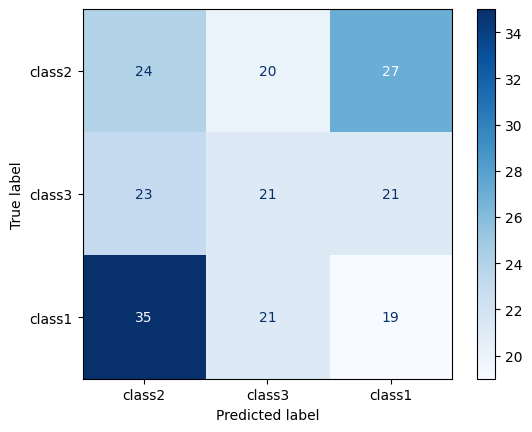

In [87]:
cmp = ConfusionMatrixDisplay(confusion_matrix, display_labels=model_lr_nb.stages[0].labels)
cmp.plot(cmap=plt.cm.Blues)

## save and load data

In [75]:
# save to local
data_path = "data/transformed_train_data_tree/"

# save to s3
# data_path = "s3a://test-thama-misc-20210612/20240717-sparkml/data/transformed_train_data_tree/"

transformed_train_data_tree.write.partitionBy("date", "geohash").mode('overwrite').save(data_path)

In [76]:
# load
transformed_train_data_tree_loaded = spark.read.load(data_path)

## save and load pipeline

In [77]:
# save to local
pipeline_model_path = "pipelines/model_tree"

# save to s3
# pipeline_model_path = "s3a://test-thama-misc-20210612/20240717-sparkml/pipelines/model_tree"

model_tree.write().overwrite().save(pipeline_model_path)

In [78]:
# load pipeline
loaded_model = PipelineModel.load(pipeline_model_path)

## create model

In [79]:
# Training the Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label_index")
rf_model = rf.fit(transformed_train_data_tree)

24/07/19 10:07:21 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 9 (= number of training instances)


## save and load model

In [80]:
# save to local
model_path = "models/rf_model/"

# save to s3
# model_path = "s3a://test-thama-misc-20210612/20240717-sparkml/models/rf_model/"

rf_model.write().overwrite().save(model_path)

In [81]:
# load model
rf_model = RandomForestClassificationModel.load(model_path)

## interpret model

In [83]:
importances_df_rf

,Feature,Importance
0,color_index,0.301543
3,milesperhour,0.298617
2,hour_index,0.258801
1,type_index,0.075918
4,age,0.065121
